# Evolving Fuzzy Systems (eFS) — Notebook 2  
### Interpretability in evolving systems (streaming + concept drift) using `evolvingfuzzysystems`

**Seminar (Day 2 / IA02)** — Universidad Carlos III de Madrid- Interpretability for evolving systems

**Author:** Prof. Dr. Paulo Vitor de Campos Souza


---

In [7]:
# If running on Colab / fresh env, uncomment:
# !pip -q install evolvingfuzzysystems river scikit-learn matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict, deque


---

In [6]:
# River: streaming datasets + drift detection
from river import datasets
from river import drift
from river import metrics

# Scalers / encoders
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder


---

In [4]:
# Evolving fuzzy systems library
# Key model for Day 2: ENFS_Uni0 (classification)
from evolvingfuzzysystems.classification import ENFS_Uni0

# Optional: a couple of regression/classification eFS models (if you want to showcase variety)
from evolvingfuzzysystems.eFS import ePL, ePL_plus, exTS, Simpl_eTS, eMG, ePL_KRLS_DISCO


---

## 1) Why “evolving interpretability” matters

In offline interpretability, the model is fixed after training.  
In streaming / non-stationary settings, **the model structure itself evolves**:

- new rules can be created when new patterns appear
- redundant rules can be merged / pruned
- consequent parameters adapt online

In this notebook we make these changes visible with:
1) prequential performance (predict → update)  
2) drift detection (ADWIN on the error stream)  
3) rule evolution: number of rules and rule visualizations (when available)


---

## 2) A stream with controlled concept drift (synthetic, didactic)

In [8]:
# A classic stream with a controllable drift moment
# We use two variants of the same generator as pre- and post-drift concepts.

stream = datasets.synth.ConceptDriftStream(
    stream=datasets.synth.Agrawal(seed=1),
    drift_stream=datasets.synth.Agrawal(seed=2),
    position=2500,
    width=1000,
    seed=42
)

# Quick peek
x0, y0 = next(iter(stream))
x0, y0


({'salary': 37467.35173461216,
  'commission': 73557.53027029245,
  'age': 68,
  'elevel': 0,
  'car': 9,
  'zipcode': 1,
  'hvalue': 696804.5609643586,
  'hyears': 15,
  'loan': 236122.6217880583},
 1)

---

## 3) Utility: stream → numpy buffers (for scaling + plotting)

In [9]:
def stream_to_arrays(stream, n_samples):
    """Collect first n_samples from a River stream into numpy arrays."""
    X_list, y_list = [], []
    it = iter(stream)
    for _ in range(n_samples):
        x, y = next(it)
        # River gives dict features -> convert to ordered vector
        X_list.append([x[k] for k in sorted(x.keys())])
        y_list.append(y)
    X = np.asarray(X_list, dtype=float)
    y = np.asarray(y_list)
    return X, y, sorted(x.keys())

N = 6000
X_raw, y_raw, feature_names = stream_to_arrays(stream, N)
X_raw.shape, y_raw.shape, feature_names[:5]


((6000, 9), (6000,), ['age', 'car', 'commission', 'elevel', 'hvalue'])

---

## 4) Preprocessing (important for Gaussian similarity)

In [10]:
# ENFS_Uni0 uses distances + Gaussian similarity -> scaling is critical.
# We'll use StandardScaler; MinMaxScaler also works well in many eFS.

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# Labels must be integer-encoded: 0..C-1
le = LabelEncoder()
y = le.fit_transform(y_raw)

n_features = X.shape[1]
n_classes = len(np.unique(y))
n_features, n_classes, le.classes_[:5]


(9, 2, array([0, 1]))

---

## 5) Model: ENFS_Uni0 (evolving rule base + RLS consequent layer)

In [11]:
model = ENFS_Uni0(
    n_features=n_features,
    n_classes=n_classes,
    lambda_ff=0.98,        # forgetting factor (lower -> faster adaptation)
    sim_threshold=0.90,    # prune very similar new rules
    max_rules=10,          # keep it interpretable in the demo
    random_state=42
)

# Drift detector on the error stream
adwin = drift.ADWIN(delta=0.002)

# Prequential metric
acc = metrics.Accuracy()

# Tracking
rule_count = []
drift_points = []
acc_hist = []


---

## 6) Prequential loop (predict → update) + rule evolution tracking

In [12]:
import numpy as np

def safe_n_rules(m):
    """Try multiple ways to get number of rules from different eFS implementations."""
    try:
        return int(m.n_rules())
    except Exception:
        pass

    for attr in ["n_rules", "rules", "rules_"]:
        if hasattr(m, attr):
            obj = getattr(m, attr)
            try:
                if callable(obj):
                    return int(obj())
                return int(len(obj))
            except Exception:
                pass

    return np.nan

def safe_metric_value(metric):
    """River metrics vary: some have .get(), others are float-castable."""
    if hasattr(metric, "get") and callable(metric.get):
        return float(metric.get())
    try:
        return float(metric)
    except Exception:
        return np.nan

def safe_predict(model, x2d, default=0):
    """Return an int prediction, whether predict returns scalar or array-like."""
    try:
        yhat = model.predict(x2d)
        if isinstance(yhat, (list, tuple, np.ndarray)):
            return int(yhat[0])
        return int(yhat)
    except Exception:
        return int(default)

def safe_online_update(model, x2d, y1d, classes=None, is_first=False):
    """
    Prefer partial_fit when available.
    Some sklearn-like APIs require `classes=` in the first call.
    """
    pf = getattr(model, "partial_fit", None)
    if callable(pf):
        if is_first and classes is not None:
            try:
                pf(x2d, y1d, classes=classes)
                return
            except TypeError:
                pass
        pf(x2d, y1d)
        return

    # fallback
    model.fit(x2d, y1d)



# ---- streaming loop ----
snapshots_at = {500, 1000, 1500, 2500, 3000, 4000, 5000, 6000}
snapshots = {}

acc_hist = []
rule_count = []
drift_points = []
classes = np.unique(y)

for t in range(N):
    x_t = X[t]
    y_t = int(y[t])

    x2d = x_t.reshape(1, -1)
    y1d = np.asarray([y_t])

    # Predict robustly
    y_hat = safe_predict(model, x2d, default=0)

    # Update metric (in-place)
    acc.update(y_t, y_hat)
    acc_hist.append(safe_metric_value(acc))

    # Drift detector on 0/1 error
    err = int(y_hat != y_t)
    out = adwin.update(err)

    # River versions differ: sometimes update returns bool, sometimes flags exist
    if (out is True) or getattr(adwin, "drift_detected", False) or getattr(adwin, "change_detected", False):
        drift_points.append(t)

    # Update model online
    safe_online_update(model, x2d, y1d, classes=classes, is_first=(t==0))

    # Track rules
    rule_count.append(safe_n_rules(model))

    # Save snapshots
    if (t + 1) in snapshots_at:
        snapshots[t + 1] = {"n_rules": rule_count[-1]}

(len(drift_points), drift_points[:5], rule_count[-1] if rule_count else None, acc_hist[-1] if acc_hist else None)


c:\Users\acer\Desktop\fnn-pso\.venv\Lib\site-packages\numpy\_core\numeric.py:994: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
c:\Users\acer\Desktop\fnn-pso\.venv\Lib\site-packages\evolvingfuzzysystems\classification.py:553: RuntimeWarning: overflow encountered in matmul
  self.P = (P - np.outer(K, phi) @ P) / lambda_ff
c:\Users\acer\Desktop\fnn-pso\.venv\Lib\site-packages\evolvingfuzzysystems\classification.py:553: RuntimeWarning: invalid value encountered in matmul
  self.P = (P - np.outer(K, phi) @ P) / lambda_ff


(0, [], 10, 0.6523333333333333)

---

## 7) Plots: performance, drift points, and number of rules

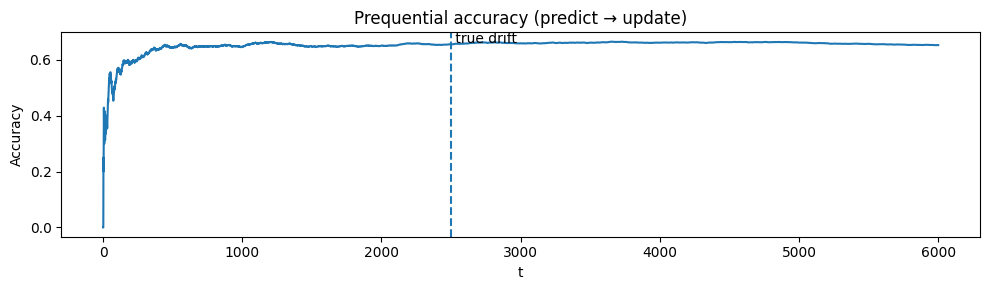

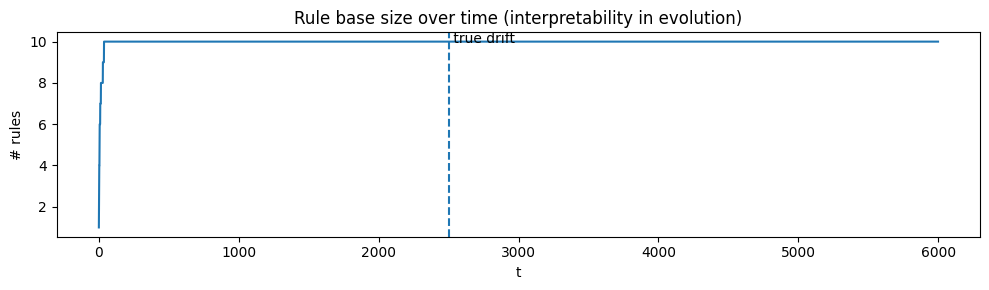

In [13]:
def plot_series_with_markers(y, title, ylabel, drift_points=None, drift_position=None):
    plt.figure(figsize=(10, 3))
    plt.plot(y)
    plt.title(title)
    plt.xlabel("t")
    plt.ylabel(ylabel)

    if drift_position is not None:
        plt.axvline(drift_position, linestyle="--")
        plt.text(drift_position, plt.ylim()[1], " true drift", va="top")

    if drift_points:
        for p in drift_points:
            plt.axvline(p, linestyle=":")

    plt.tight_layout()
    plt.show()

# True drift (from generator settings)
TRUE_DRIFT_POS = 2500

plot_series_with_markers(
    acc_hist,
    title="Prequential accuracy (predict → update)",
    ylabel="Accuracy",
    drift_points=drift_points,
    drift_position=TRUE_DRIFT_POS
)

plot_series_with_markers(
    rule_count,
    title="Rule base size over time (interpretability in evolution)",
    ylabel="# rules",
    drift_points=drift_points,
    drift_position=TRUE_DRIFT_POS
)


---

## 8) Interpretable snapshots (rules / Gaussians / rule evolution)

The following visualizations are provided by `evolvingfuzzysystems` for ENFS_Uni0:

- `plot_rules()`
- `plot_gaussians()`
- `plot_rules_evolution()`

We'll call them safely (so the notebook still runs even if a backend is missing).


In [17]:
def safe_call_plot(fn, title=None):
    try:
        if title:
            print(title)
        fn()
    except Exception as e:
        print(f"[skip plot] {e}")

print("Final #rules:", safe_n_rules(model))

# Visualizations (if available in your environment)
safe_call_plot(model.rules, title="Plot rules (final model)")


Final #rules: 10
Plot rules (final model)
[skip plot] 'list' object is not callable


---

## 9) “Explain one prediction” (local interpretability hook)

A simple way to make interpretability concrete in a talk:
1) take a single sample `x_t`  
2) find which rule(s) fired most strongly  
3) show their parameters / antecedent regions

The ENFS_Uni0 API may not expose firing strengths directly; if not,
you can still show:
- nearest rule center (by Gaussian similarity)
- which rules are currently in the knowledge base

Below is a lightweight template: it tries to access internal rule storage
and prints the first few rules.


In [18]:
# Best-effort rule inspection (will depend on internal attributes)
def inspect_rules(m, max_rules=3):
    for attr in ["rules", "rules_", "R", "R_"]:
        if hasattr(m, attr):
            rules = getattr(m, attr)
            try:
                rules = rules() if callable(rules) else rules
                print(f"Found rules in attribute: {attr} (showing up to {max_rules})")
                # Print a shallow view
                if isinstance(rules, dict):
                    for i, (k, v) in enumerate(rules.items()):
                        if i >= max_rules:
                            break
                        print(f"- rule {k}: {str(v)[:300]}")
                else:
                    for i, r in enumerate(list(rules)[:max_rules]):
                        print(f"- rule {i}: {str(r)[:300]}")
                return
            except Exception:
                pass
    print("Could not access internal rule storage in a stable way. Use model.plot_* instead.")

inspect_rules(model, max_rules=5)


Found rules in attribute: rules (showing up to 5)
- rule 0: Uni0Rule(center=array([ 0.24822816,  0.37846466,  0.48518391, -0.39488805, -0.24187805,
       -0.3816053 , -0.60074034, -0.79063606,  0.12971514]), sigma=2.1208491198504875, support=108, w=array([0.69736803, 0.09417735, 0.97562235, 0.7611397 , 0.78606431,
       0.12811363, 0.45038594, 0.37079802, 
- rule 1: Uni0Rule(center=array([ 0.11515973,  0.13478465, -0.66026942, -0.67884783, -0.18722504,
        0.71140306, -0.49542621,  0.62409347,  0.10122193]), sigma=2.120020562685213, support=134, w=array([0.22723872, 0.55458479, 0.06381726, 0.82763117, 0.6316644 ,
       0.75808774, 0.35452597, 0.97069802, 0
- rule 2: Uni0Rule(center=array([ 0.22853471, -0.44161611, -0.7172779 ,  0.65135098, -0.56720919,
       -0.3092756 , -0.02317714,  0.62353445,  0.59256541]), sigma=2.1211965936142607, support=149, w=array([0.66981399, 0.43715192, 0.8326782 , 0.7002651 , 0.31236664,
       0.8322598 , 0.80476436, 0.38747838, 
- rule 3: Uni0Rul

---

## 10) Optional extension: replace synthetic stream with a real drifting dataset

Two common choices in River:
- `datasets.Elec2()` (electricity market, drift)
- `datasets.CreditCard()` (extreme imbalance)

For your talk: Elec2 is usually “cleaner” for showing drift + adaptation.


In [19]:
# Uncomment to try Elec2 quickly
real_stream = datasets.Elec2()
x, y = next(iter(real_stream))
x, y


({'date': 0.0,
  'day': 2,
  'period': 0.0,
  'nswprice': 0.056443,
  'nswdemand': 0.439155,
  'vicprice': 0.003467,
  'vicdemand': 0.422915,
  'transfer': 0.414912},
 True)

## 11) Paper-style comparative experiment (multiple eFS models)

This section reproduces a **paper-like** comparison across several **evolving fuzzy systems** from `evolvingfuzzysystems`:

- `ePL`, `ePL_plus`, `exTS`, `Simpl_eTS`, `eMG`, `ePL_KRLS_DISCO`
- `ENFS_Uni0` (classification)

**Protocol (aligned with my previous scripts):**
- Stream → NumPy `(X, y_int)`
- Min–max scaling of `X` to `[0, 1]` (recommended by the library)
- **Prequential evaluation** (predict-then-update) with:
  - Warmup (`warmup`) and then **chunked evolution** (`chunk_size`) for models that use `evolve()`
  - For models that do not expose `evolve()`, we try `partial_fit()` or fall back to `fit()` on chunks (some evolving models implement `fit()` as an online pass).

> Tip for live presentations: keep `n_max` small (e.g. 2000–5000) and use only 1–2 datasets to run fast.

---

In [ ]:
# -----------------------------
# Robust benchmark (hybrid) for extra-time demo
# -----------------------------
import numpy as np
import pandas as pd
from time import perf_counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

def _ensure_1d_float(y): return np.asarray(y).ravel().astype(np.float64)
def _ensure_1d_int(y):   return np.asarray(y).ravel().astype(int)

def _predict_score_scalar(model, x_row):
    yhat = model.predict(x_row)
    if isinstance(yhat, (list, tuple)):
        yhat = yhat[0] if len(yhat) else 0.0
    arr = np.asarray(yhat)
    return float(arr.ravel()[0]) if arr.size else 0.0

def _n_rules(model):
    if hasattr(model, "n_rules") and callable(getattr(model, "n_rules")):
        try: return int(model.n_rules())
        except: pass
    for attr in ["rules", "rules_"]:
        if hasattr(model, attr):
            try: return int(len(getattr(model, attr)))
            except: pass
    return np.nan

def rolling_mean(x, window):
    x = np.asarray(x, float)
    out = np.full_like(x, np.nan, dtype=float)
    c = np.cumsum(np.insert(x, 0, 0.0))
    for i in range(1, len(x)+1):
        j0 = max(0, i-window)
        out[i-1] = (c[i] - c[j0]) / (i - j0)
    return out

def prequential_hybrid(model, X_raw, y_int, warmup=200, batch_evolve=100, rolling_window=250, threshold=0.5):
    X_raw = np.asarray(X_raw, dtype=np.float64)
    y_int = _ensure_1d_int(y_int)
    X_raw = np.nan_to_num(X_raw, nan=0.0, posinf=1.0, neginf=0.0)

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X_raw)

    n = len(y_int)
    warmup = min(warmup, n)

    has_evolve = hasattr(model, "evolve") and callable(getattr(model, "evolve", None))
    has_partial = hasattr(model, "partial_fit") and callable(getattr(model, "partial_fit", None))
    mode = "evolve" if has_evolve else ("partial_fit" if has_partial else "fit_batch")

    classes = np.unique(y_int)

    # warmup
    if has_evolve:
        y0 = _ensure_1d_float(y_int[:warmup])
        try: model.fit(X[:warmup], y0)
        except: model.fit(X[:warmup], y0.reshape(-1,1))
    elif has_partial:
        for i in range(warmup):
            xi = X[i:i+1]
            yi = y_int[i:i+1]
            if i == 0:
                try: model.partial_fit(xi, yi, classes=classes)
                except TypeError: model.partial_fit(xi, yi)
            else:
                model.partial_fit(xi, yi)
    else:
        y0 = _ensure_1d_float(y_int[:warmup])
        try: model.fit(X[:warmup], y0)
        except: model.fit(X[:warmup], y0.reshape(-1,1))

    y_true, y_pred = [], []
    correct_stream = []
    acc_batch, rules_hist = [], []
    bufX, bufy = [], []

    for t in range(warmup, n):
        x_t = X[t:t+1]
        y_t = int(y_int[t])

        score = _predict_score_scalar(model, x_t)
        y_hat = int(score >= threshold)

        y_true.append(y_t); y_pred.append(y_hat)
        correct_stream.append(1.0 if y_hat == y_t else 0.0)

        if mode == "evolve":
            bufX.append(x_t.ravel()); bufy.append(float(y_int[t]))
            if len(bufy) >= batch_evolve:
                Xb = np.vstack(bufX)
                yb = _ensure_1d_float(np.array(bufy))
                try: model.evolve(Xb, yb)
                except: model.evolve(Xb, yb.reshape(-1,1))
                bufX, bufy = [], []
        elif mode == "partial_fit":
            model.partial_fit(x_t, np.array([y_t], dtype=int))
        else:
            bufX.append(x_t.ravel()); bufy.append(float(y_int[t]))
            if len(bufy) >= batch_evolve:
                Xb = np.vstack(bufX)
                yb = _ensure_1d_float(np.array(bufy))
                try: model.fit(Xb, yb)
                except: model.fit(Xb, yb.reshape(-1,1))
                bufX, bufy = [], []

        if (t - warmup + 1) % batch_evolve == 0:
            acc_batch.append(accuracy_score(np.asarray(y_true), np.asarray(y_pred)))
            rules_hist.append(_n_rules(model))

    correct_stream = np.asarray(correct_stream, float)
    acc_roll = rolling_mean(correct_stream, rolling_window)

    return {"acc_batch": np.asarray(acc_batch),
            "acc_roll": acc_roll,
            "rules": np.asarray(rules_hist),
            "correct_stream": correct_stream,
            "mode": mode}

# Example: quick extra benchmark on Elec2 arrays (Xr, yr)
warmup = 500
batch_evolve = 100
rolling_window = 400
threshold = 0.5

MODELS_REAL = [
    ("ENFS_Uni0", lambda: ENFS_Uni0(n_features=X_raw.shape[1], n_classes=len(np.unique(y_raw)),
                                   lambda_ff=0.99, sim_threshold=0.95, max_rules=10, random_state=42)),
    ("ePL", lambda: ePL()),
    ("exTS", lambda: exTS()),
    ("eMG", lambda: eMG()),
]

results_real = {}
rows = []
failed = []

for name, ctor in MODELS_REAL:
    print("Running:", name)
    t0 = perf_counter()
    try:
        res = prequential_hybrid(ctor(), X_raw, y_raw, warmup=warmup, batch_evolve=batch_evolve,
                                rolling_window=rolling_window, threshold=threshold)
        dt = perf_counter() - t0
        results_real[name] = res
        rows.append({"model": name, "mode": res["mode"],
                     "final_acc_batch": float(res["acc_batch"][-1]) if len(res["acc_batch"]) else np.nan,
                     "mean_acc_batch": float(np.mean(res["acc_batch"])) if len(res["acc_batch"]) else np.nan,
                     "final_rules": float(res["rules"][-1]) if len(res["rules"]) else np.nan,
                     "runtime_s": float(dt)})
    except Exception as e:
        print(f"  ✗ Failed: {name} -> {repr(e)} (skipping)")
        failed.append(name)

df_extra = pd.DataFrame(rows).sort_values("final_acc_batch", ascending=False)
print("Failed:", failed)
df_extra


Running: ENFS_Uni0


c:\Users\acer\Desktop\fnn-pso\.venv\Lib\site-packages\numpy\_core\numeric.py:994: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
c:\Users\acer\Desktop\fnn-pso\.venv\Lib\site-packages\evolvingfuzzysystems\classification.py:553: RuntimeWarning: overflow encountered in matmul
  self.P = (P - np.outer(K, phi) @ P) / lambda_ff
c:\Users\acer\Desktop\fnn-pso\.venv\Lib\site-packages\evolvingfuzzysystems\classification.py:553: RuntimeWarning: invalid value encountered in matmul
  self.P = (P - np.outer(K, phi) @ P) / lambda_ff


Running: ePL
Running: exTS
Running: eMG
Failed: []


,model,mode,final_acc_batch,mean_acc_batch,final_rules,runtime_s
0,ENFS_Uni0,fit_batch,0.811091,0.784701,30.0,48.262497
3,eMG,evolve,0.683636,0.687918,67.0,439.929412
1,ePL,evolve,0.676364,0.680646,1.0,4.281058
2,exTS,evolve,0.674000,0.675940,3.0,15.895810
